# Prepare Tomogram and Pre-Segmented Data for Training

This notebook describes how we define and collect the data from the various parts of the tomogram. After loading, we spit out another hdf file that can be used for training purposes. This file contains essentially a hdf file with cubes of data from the tomogram - one leaf (raw) containing the raw density values from the native tomogram, and another leaf (onehot) containing the corresponding matrix of the 'one-hot' class (ie which label each voxel represents) (zero means empty data)

## Define some utility methods

In [1]:
import h5py
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
def load_image( filepath, leaf='MDF/images/0/image', normalise=255, astype='uint8' ):
    """ load the specified hdf file and look for a 3d intensity map; normalise output """
    f = h5py.File(filepath)
    # f.visit(print)

    d = f[leaf].value
    print('%s, shape: %s' % (filepath, d.shape,))
    n = np.min(d)
    m = np.max(d)
    out = ( (d - n) * (1/(m - n)) * normalise ).astype(astype)
    print('  min: %s->%s, max: %s->%s, mean: %s->%s, std: %s->%s' % (n,np.min(out), m,np.max(out), np.mean(d),np.mean(out), np.std(d),np.std(out),))
    
    return out, d.shape


In [3]:
def show( data, title=None, low_pass_filter=0 ):
    """ crude display out data """
    vmin=np.min(data)
    vmax=np.max(data)
    
    fig=plt.figure()
    if title:
        fig.suptitle(title, fontsize=16)
        
    x,y,z=np.where(data>low_pass_filter)
    v=data[np.where(data>low_pass_filter)]
    
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(x,y,z, c=v, marker='.', vmin=vmin,vmax=vmax, s=1)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    return plt.show()


In [4]:
def crop( data, x=None, y=None, z=None, astype='uint8'):
    """ crop out a 3d portion of the 3d matrix with tuples as defined on axes """
    def _slice( tup ):
        return slice(None) if not tup else slice(tup[0],tup[1])
    return data[ _slice(x), _slice(y), _slice(z)].astype(astype)


In [5]:
def load_tomogram( d ):
    data = {}
    dim = None
    for (label,filepath) in d.items():
        data[label], this_dim = load_image(filepath)
        if not dim:
            dim = this_dim
        else:
            if not dim == this_dim:
                raise IOException("Inconsistent tomogram dimensions for %s, expecting %s (got %s)" % (filepath,dim,this_dim))
    return data, dim

In [6]:
def get_onehot( tomo, dimension, low_pass_filter=None, classes={
    'empty': 0,
    'actin': 1,
    'membrane': 2,
    'microtuble': 3,
#     'tube': 4
} ):
    """ given the tomogram (dict with key=label name and value=numpy array of 3d matrix, determine which class is most likely at each voxel """
    cube = np.empty( [len(classes),dimension[0],dimension[1],dimension[2]] )
    cube[0] = np.zeros( dimension )
    for (label, class_number) in classes.items():
        if label != 'empty':
            data = tomo[label]
            if low_pass_filter:
                data[data<low_pass_filter] = 0
            # print( '%s -> %s:\n%s' % (label,classes[label],data))
            cube[class_number] = data
    # print("cube: ")
    # print( cube )
    return cube.argmax( axis=0 )

## Load some data

Define the set of hdf files to load and load the entire tomogram

In [7]:
base_dir="/gpfs/slac/cryo/fs1/g/tomo-seg/mut_05/"
tomo, dimensions = load_tomogram( {
    'raw':        base_dir+"/rawtomograms/raw_tomo_bin4.hdf",
    'actin':      base_dir+"/tomoseg_actin3_bin2.hdf",
    'membrane':   base_dir+"/tomoseg_memb2.hdf",
    'microtuble': base_dir+"/tomoseg_mt.hdf",
    'tube':       base_dir+"/tomoseg_tubenearmt_bin2.hdf",
} )

/gpfs/slac/cryo/fs1/g/tomo-seg/mut_05//rawtomograms/raw_tomo_bin4.hdf, shape: (62, 1280, 960)
  min: -3.0->0, max: 3.0->255, mean: 0.0053402698->127.2324651640205, std: 0.9488565->40.320958669870464
/gpfs/slac/cryo/fs1/g/tomo-seg/mut_05//tomoseg_actin3_bin2.hdf, shape: (62, 1280, 960)
  min: -0.06881775->0, max: 2.9694102->255, mean: 0.03241927->7.916089575982863, std: 0.093509994->7.8817281218940805
/gpfs/slac/cryo/fs1/g/tomo-seg/mut_05//tomoseg_memb2.hdf, shape: (62, 1280, 960)
  min: -0.0908308->0, max: 1.5630476->255, mean: 0.0016439599->13.859961935063843, std: 0.021104122->3.2798332437476136
/gpfs/slac/cryo/fs1/g/tomo-seg/mut_05//tomoseg_mt.hdf, shape: (62, 1280, 960)
  min: -0.0389266->0, max: 1.3787652->255, mean: 0.020886332->10.266881956695228, std: 0.049475484->8.90135117322233
/gpfs/slac/cryo/fs1/g/tomo-seg/mut_05//tomoseg_tubenearmt_bin2.hdf, shape: (62, 1280, 960)
  min: -0.03544575->0, max: 2.370061->254, mean: 0.055367813->9.103495503087197, std: 0.07107121->7.557947309

Now we need to determine the 'one-hot' matrix of which class occupies each and every voxel. This one-hot matrix is indexed as per the the classes parameter (which should match the label of the loaded files)

In [8]:
onehot = get_onehot( tomo, dimensions, low_pass_filter=16 )

## Quick check of the data

Let's show a small section just to ensure that we have the correct data

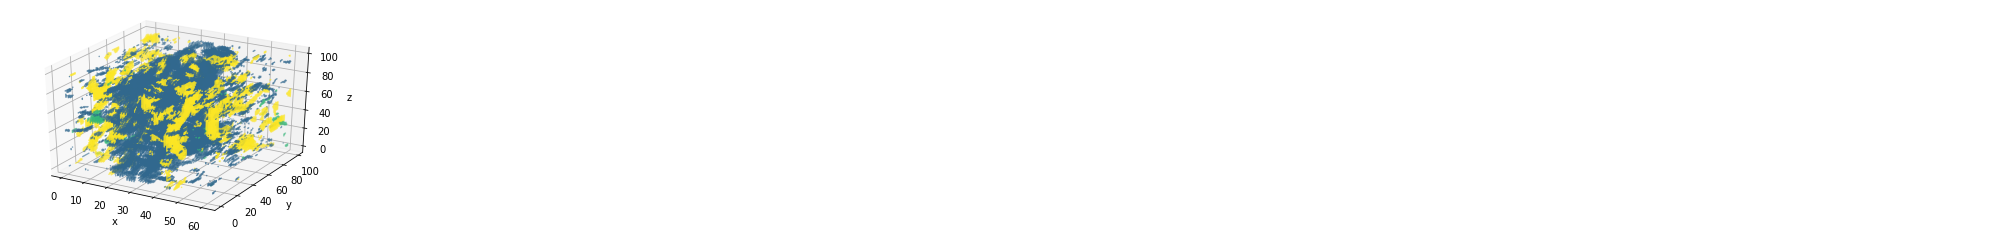

In [18]:
show( crop( onehot, x=None, y=(400,500), z=(400,500) ) )

In [41]:
with h5py.File('mut05.hdf', 'w') as f:
    f.create_dataset('onehot', data=one_hot.reshape(1,one_hot.size))
    f.create_dataset('raw', data=all_data['raw'].reshape(1,all_data['raw'].size))

lets reread the file and reconstruct to make sure it's good

In [44]:
def load_tomo( filepath, shape=(62,1280,960) ):
    f = h5py.File(filepath)
#     f.visit(print)
    raw = f['raw'].value.reshape( shape )
    onehot = f['onehot'].value.reshape( shape )
    return raw, onehot
raw_data, onehot_data = load_tomo( 'mut05.hdf' )

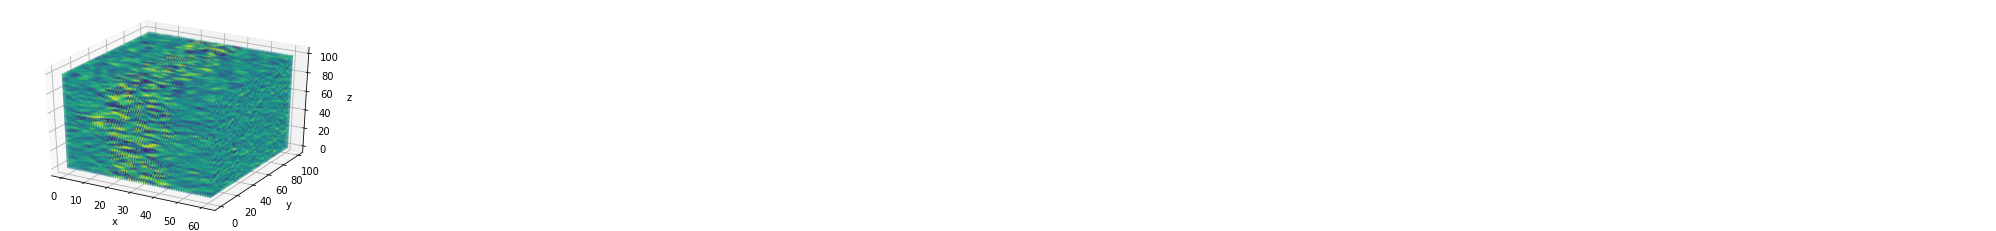

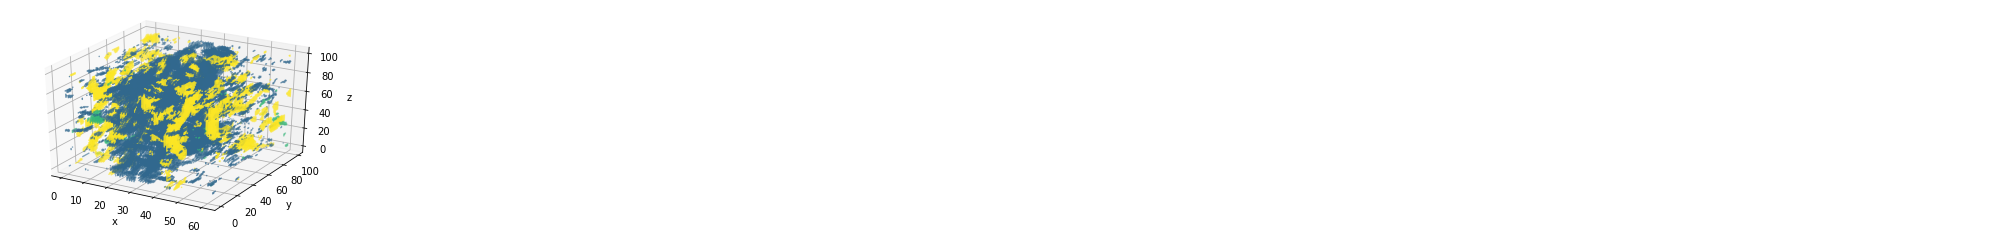

In [48]:
show( crop( raw_data, x=None, y=(400,500), z=(400,500) ) )
show( crop( onehot_data, x=None, y=(400,500), z=(400,500) ) )

## Create training data

create many little cubes for training. store as 1d array of 1d cubes

In [22]:
def generate_training_data( tomo, onehot, dimensions, size=64, iterations=100000, seed=200, astype='uint8' ):
    np.random.seed(seed)
    def get_random( size=size, x=dimensions[0], y=dimensions[1], z=dimensions[2] ):
        dx = np.random.randint(low=0, high=x-size)
        dy = np.random.randint(low=0, high=y-size)
        dz = np.random.randint(low=0, high=z-size)
        return (dx,dx+size), (dy,dy+size), (dz,dz+size)

    for i in range(iterations):
        dx,dy,dz = get_random(size=size)
        # print("%s: %s, %s, %s" % (i,dx,dy,dz) )
        yield i, crop( tomo['raw'], x=dx, y=dy, z=dz, astype='uint8'), crop( onehot, x=dx, y=dy, z=dz, astype=astype)

In [23]:
def write_training_data( filepath, tomo, onehot, dimensions, size=64, iterations=100, seed=200, display=False, astype='uint8' ):
    shape = (iterations, size**3)
#    print( 'shape: %s' % (shape,))
    with h5py.File( filepath, 'w' ) as f:
        raw = f.create_dataset('raw', shape, astype)
        one = f.create_dataset('onehot', shape, astype)
        # get some cubes!
        for i, r,o in generate_training_data( tomo, onehot, dimensions, size=size, iterations=iterations, seed=seed, astype=astype ):
#             print("i=%s\n  r %s: %s\n  o %s: %s" % (i,r.shape,r,o.shape,o))
            raw[i] = r.reshape( (1,r.size) )[0]
            one[i] = o.reshape( (1,o.size) )[0]
            if show:
                show( r )
                show( o )

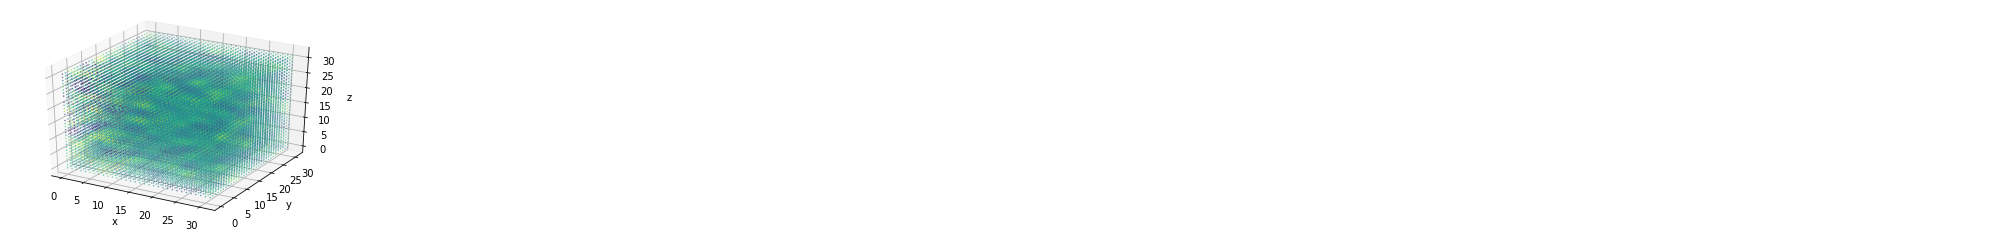

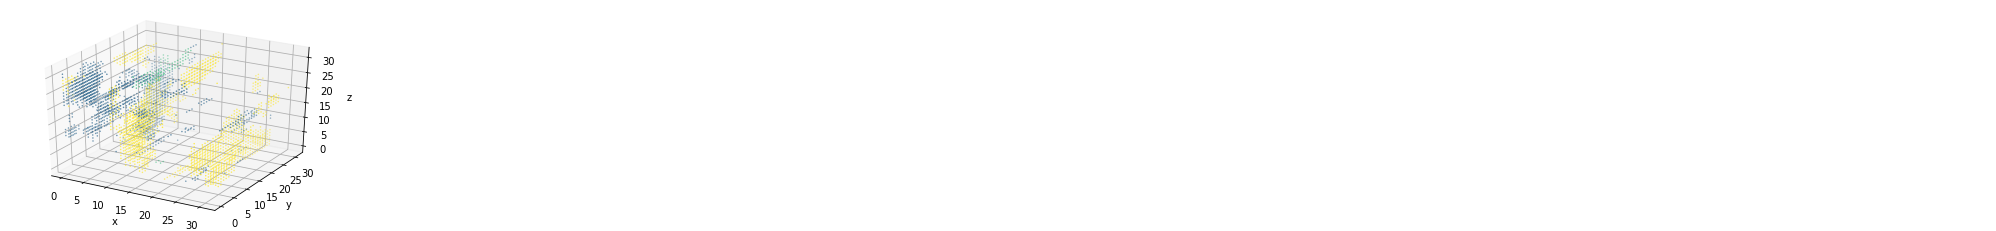

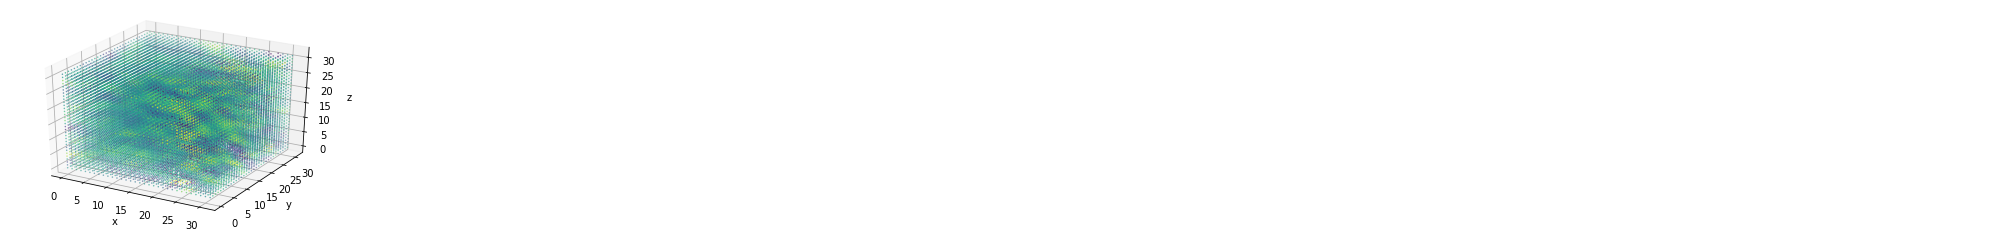

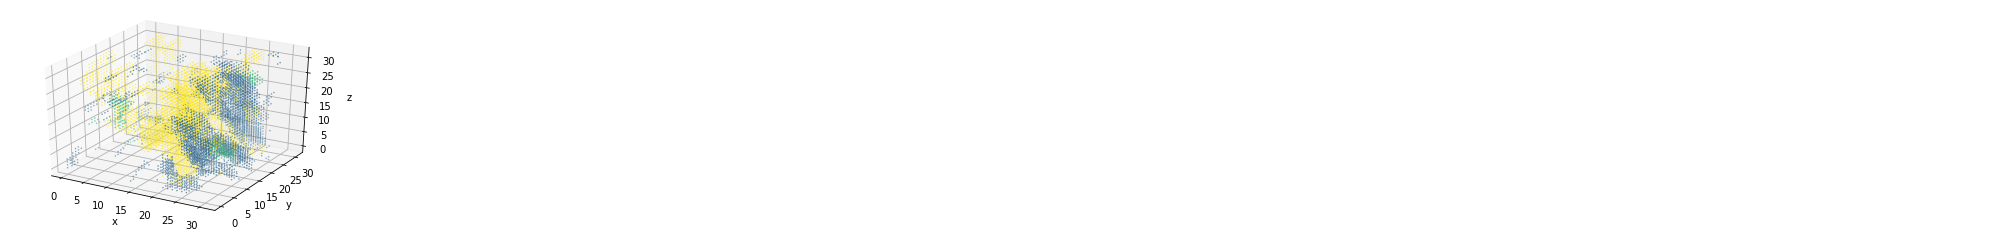

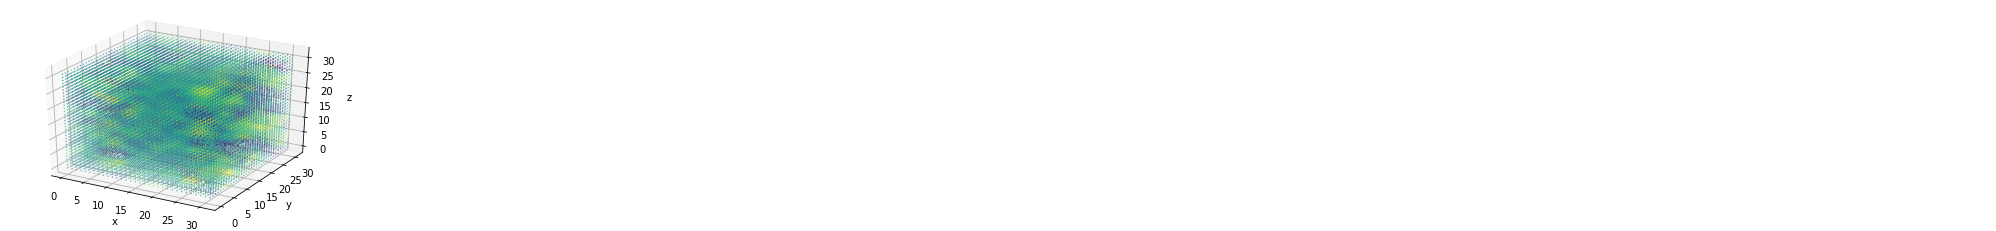

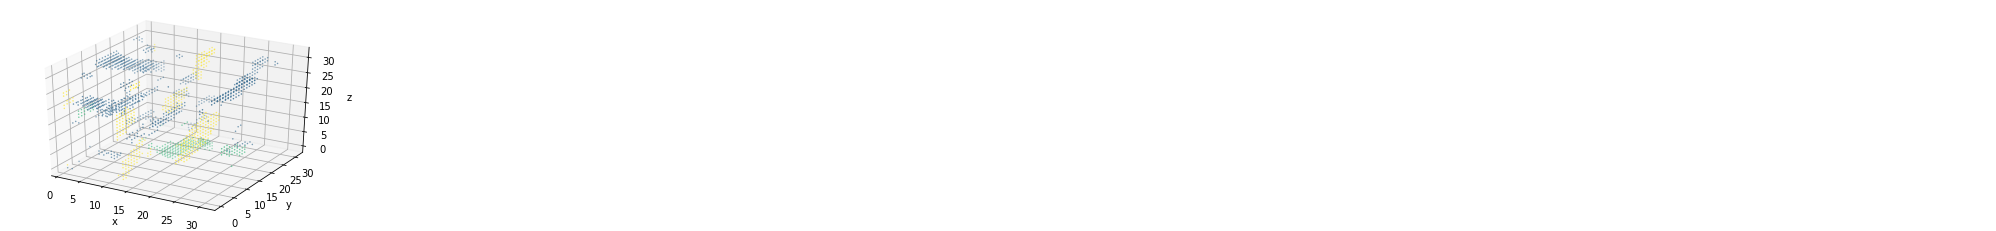

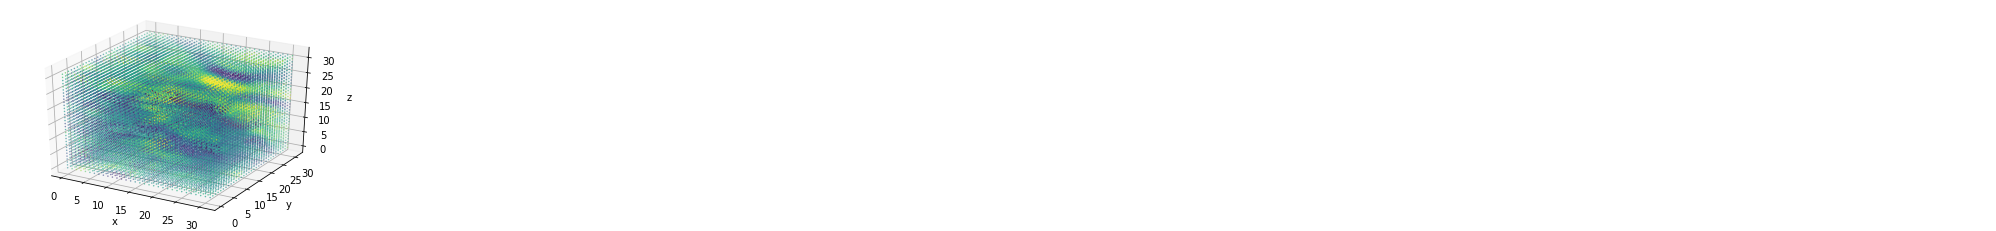

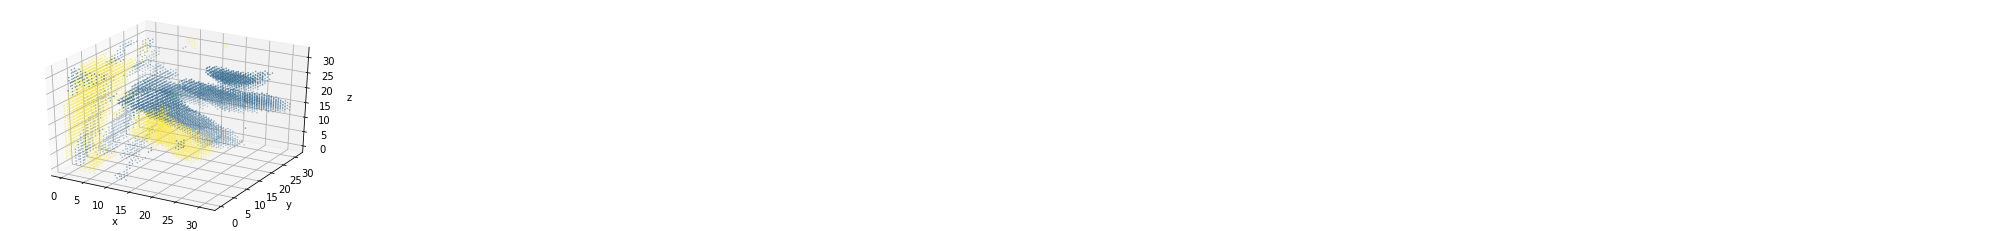

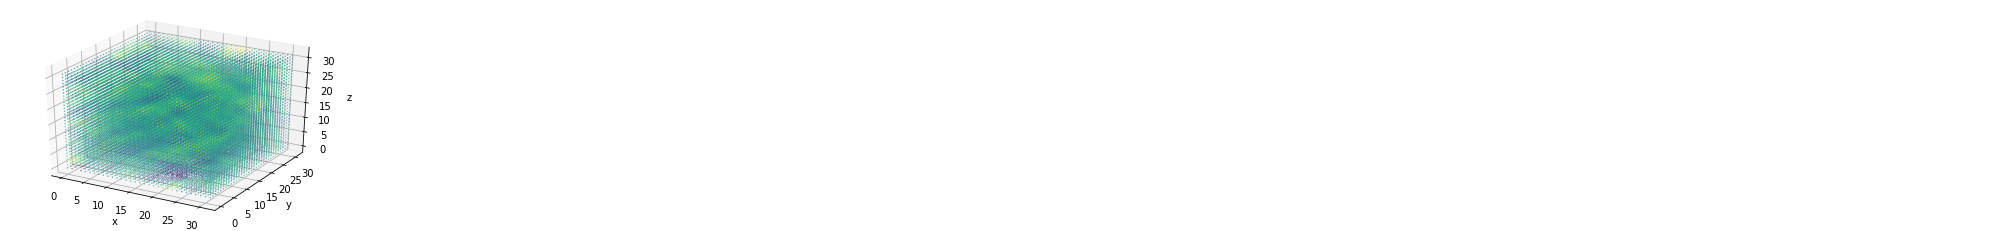

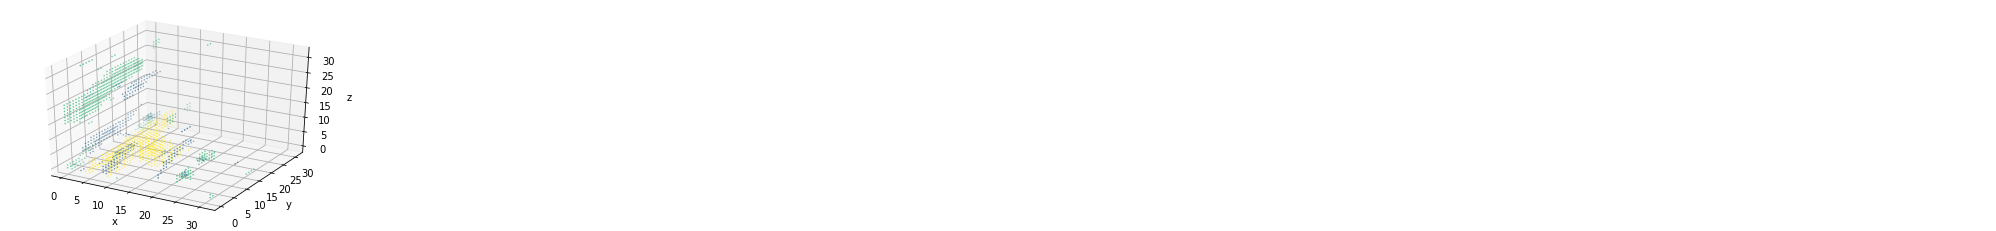

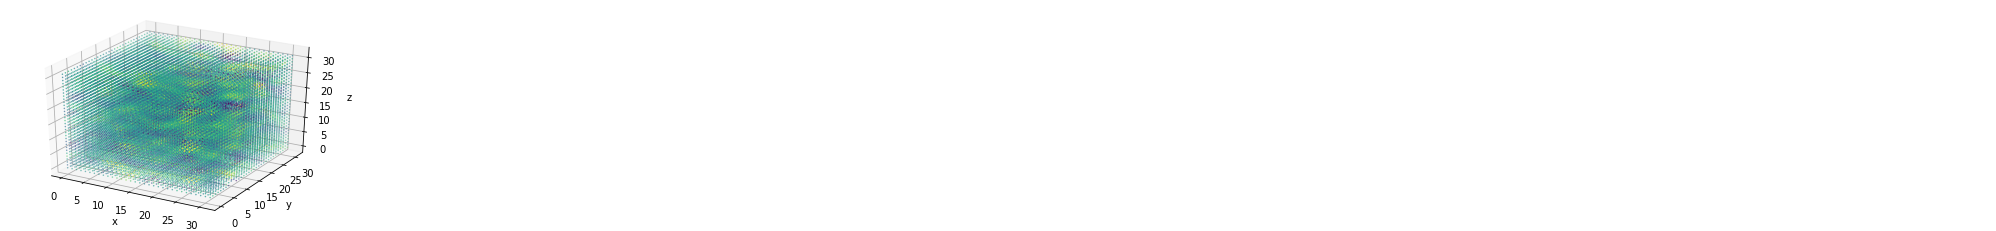

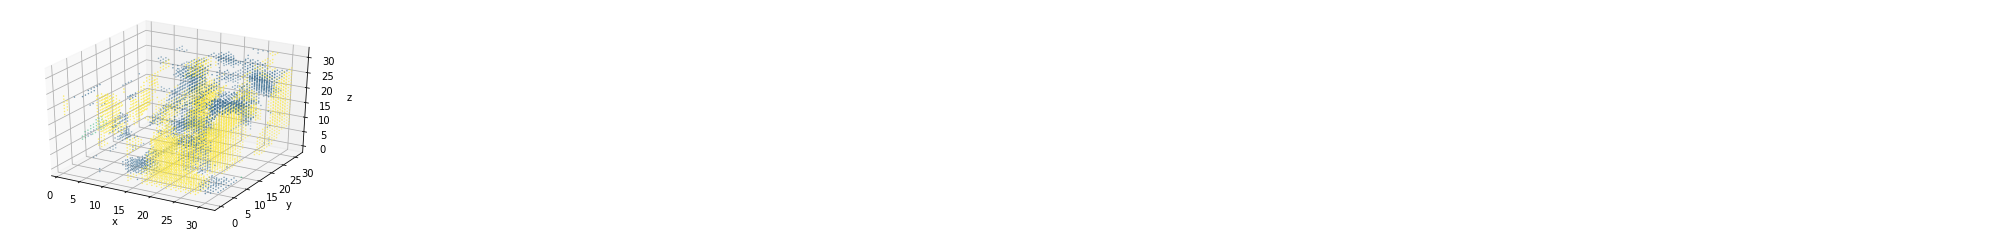

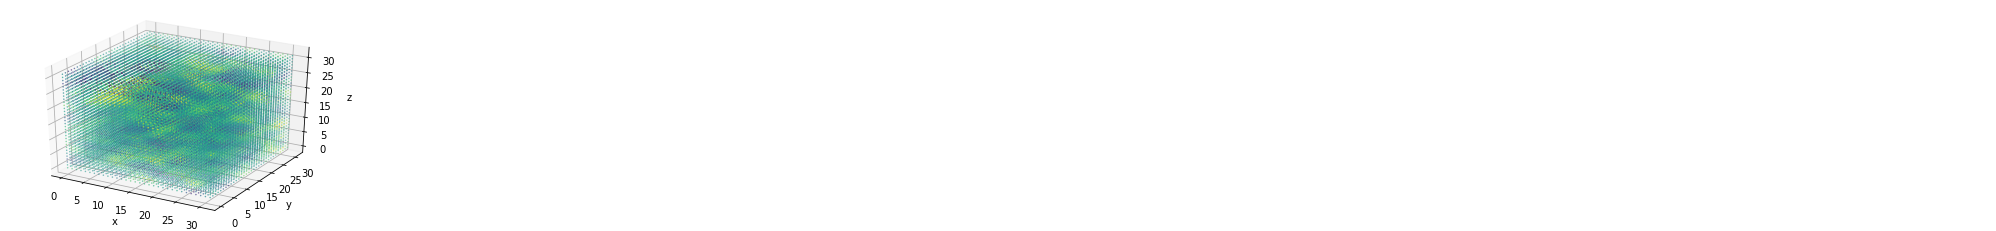

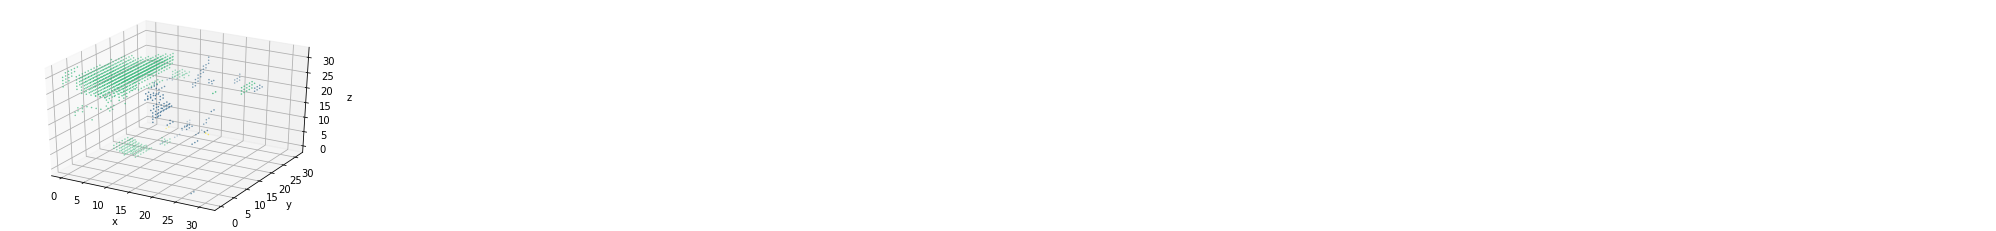

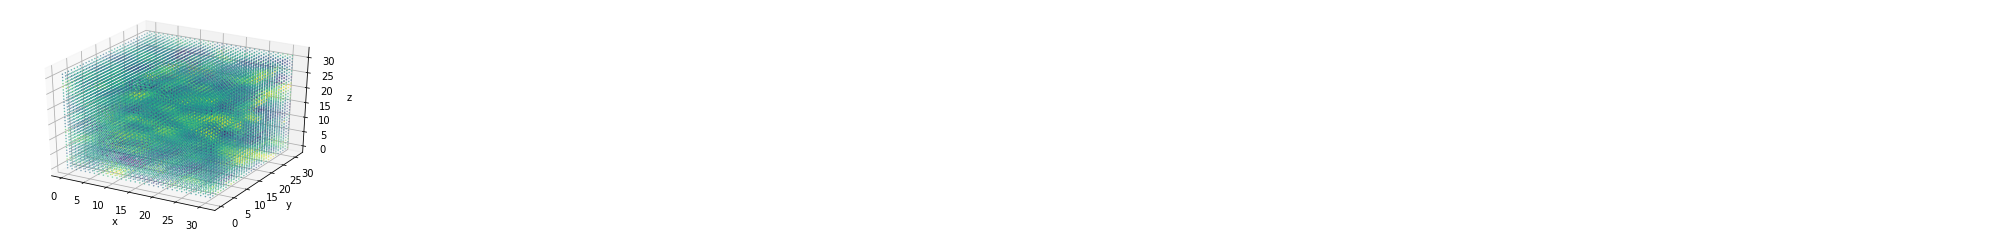

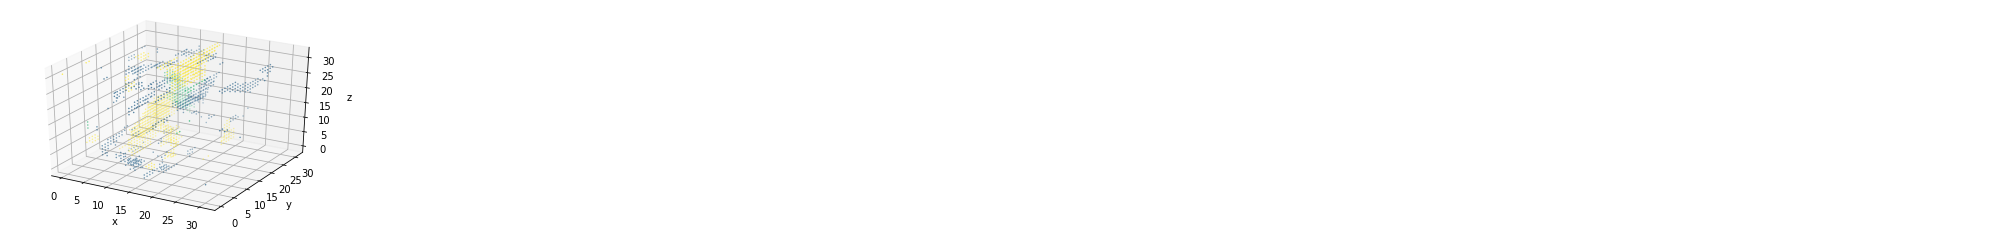

In [ ]:
write_training_data( 'mut05-training.hdf', tomo, onehot, dimensions, size=32, iterations=10, display=True )

reread the file just to make sure it looks okay

In [ ]:
with h5py.File('mut05-training.hdf','r') as f:
    print( f['raw'].value )
    print( f['onehot'].value )